<a href="https://colab.research.google.com/github/lyqht/googleplaystore-analytics/blob/master/notebooks/predict_rating_from_sentiment_polarity.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import pandas as pd
import numpy as np

df = pd.read_csv("https://raw.githubusercontent.com/lyqht/googleplaystore-analytics/master/data/reviews_joined.csv", index_col=0)
df.dropna(inplace=True)
df.reset_index(inplace=True)
df.drop("index", axis=1,inplace=True)
df.drop_duplicates(subset=["Preprocessed_Review","App"],inplace=True, keep="first")
df['Price'] = df['Price'].str.replace('$', '')
df['Price'] = df['Price'].astype(float)
df.columns

Index(['App', 'Review', 'Preprocessed_Review', 'Category', 'Average_Rating',
       'Rating_Label', 'Num_Reviews', 'Size', 'Installs', 'Type', 'Price',
       'Content Rating', 'Genres', 'Tokens', 'Sentiment', 'Neutral Proportion',
       'Positive Proportion', 'Negative Proportion', 'Compound Score',
       'Sentiment_Rating'],
      dtype='object')

NORMALIZE ALL INPUTS FROM 0-1

LABEL - SENTIMENT_RATING FROM 0-1 LABEL - CATEGORY/ GENRES MULTICLASSENCODER

In [0]:
from sklearn import preprocessing
min_max_scaler = preprocessing.MinMaxScaler()
from sklearn.preprocessing import LabelEncoder, OneHotEncoder

columns_to_normalize = ["Average_Rating", "Installs", "Price", "Size", "Sentiment_Rating"]
for col in columns_to_normalize:
  data_scaled = min_max_scaler.fit_transform(df[col].to_numpy().reshape(-1,1))
  df[col] = data_scaled

columns_to_encode = ["Category", "Genres"]
for col in columns_to_encode:
  df[col] = LabelEncoder().fit_transform(df[col])

df.head(2)

,App,Review,Preprocessed_Review,Category,Average_Rating,Rating_Label,Num_Reviews,Size,Installs,Type,Price,Content Rating,Genres,Tokens,Sentiment,Neutral Proportion,Positive Proportion,Negative Proportion,Compound Score,Sentiment_Rating
0,10 Best Foods for You,I like eat delicious food. That's I'm cooking ...,like delicious food cooking food case best foo...,15,0.608696,5,2490,0.038301,0.000499,Free,0.0,Everyone,29,"['i', 'like', 'eat', 'delicious', 'food', 'tha...",Positive,0.466,0.534,0.0,0.9531,0.978082
1,10 Best Foods for You,This help eating healthy exercise regular basis,help eating healthy exercise regular basis,15,0.608696,4,2490,0.038301,0.000499,Free,0.0,Everyone,29,"['this', 'help', 'eating', 'healthy', 'exercis...",Positive,0.481,0.519,0.0,0.6597,0.829908


In [0]:
from sklearn import preprocessing
min_max_scaler = preprocessing.MinMaxScaler()
from sklearn.preprocessing import LabelEncoder, OneHotEncoder

columns_to_normalize = ["Average_Rating", "Installs", "Price", "Size", "Sentiment_Rating"]
for col in columns_to_normalize:
  data_scaled = min_max_scaler.fit_transform(df[col].to_numpy().reshape(-1,1))
  df[col] = data_scaled

columns_to_encode = ["Category", "Genres"]
for col in columns_to_encode:
  df[col] = LabelEncoder().fit_transform(df[col])

df.head(2)

,App,Review,Preprocessed_Review,Category,Average_Rating,Rating_Label,Num_Reviews,Size,Installs,Type,Price,Content Rating,Genres,Tokens,Sentiment,Neutral Proportion,Positive Proportion,Negative Proportion,Compound Score,Sentiment_Rating
0,10 Best Foods for You,I like eat delicious food. That's I'm cooking ...,like delicious food cooking food case best foo...,15,0.608696,5,2490,0.038301,0.000499,Free,0.0,Everyone,29,"['i', 'like', 'eat', 'delicious', 'food', 'tha...",Positive,0.466,0.534,0.0,0.9531,0.978082
1,10 Best Foods for You,This help eating healthy exercise regular basis,help eating healthy exercise regular basis,15,0.608696,4,2490,0.038301,0.000499,Free,0.0,Everyone,29,"['this', 'help', 'eating', 'healthy', 'exercis...",Positive,0.481,0.519,0.0,0.6597,0.829908


In [0]:
print("Number of apps that have reviews")
df["App"].nunique()

Number of apps that have reviews


531

In [0]:
num_reviews_per_app = list(df.groupby(["App","Average_Rating"]).size())
min_num_reviews = int(np.percentile(num_reviews_per_app,25))
#min_num_reviews = 0 # temporirily edited for debugging 
print(f"25th percentile of the count of reviews :", min_num_reviews)

25th percentile of the count of reviews : 26


In [0]:
num_reviews_per_app = 28
to_keep = df.App.value_counts()[df.App.value_counts() >= num_reviews_per_app].index
print("Number of Apps that have at least ",num_reviews_per_app, "reviews :", len(to_keep))

df = df[df.App.isin(to_keep)]

Number of Apps that have at least  28 reviews : 380


In [0]:
unique_apps = to_keep

print("Creating an array containing arrays of reviews of different apps")
reviews_by_app = [df[df["App"] == unique_apps[i]]["Preprocessed_Review"].to_numpy() for i in range(len(to_keep))]
reviews_by_app
print("Creating an array containing arrays of reviews' sentiment polarity of different apps")
review_sentiment_by_app = [df[df["App"] == unique_apps[i]]["Sentiment_Rating"].to_numpy() for i in range(len(to_keep))]

print("Creating an array containing the actual average rating of different apps")
avr_rating_per_app = [df[df["App"] == unique_apps[i]]["Average_Rating"].to_numpy() for i in range(len(to_keep))]

Creating an array containing arrays of reviews of different apps
Creating an array containing arrays of reviews' sentiment polarity of different apps
Creating an array containing the actual average rating of different apps


In [0]:
from torch import tensor
from torch.autograd import Variable
from torch.utils.data import Dataset
from torch.utils.data import DataLoader, random_split

class SentimentDataset(Dataset):
  global num_reviews_per_app
  def __init__(self, x, y):
    self.samples = x
    self.labels = y
  
  def __len__(self):
    return len(self.samples)
  
  def __getitem__(self,idx):
    item = self.samples[idx]
    item = np.random.choice(item, size=num_reviews_per_app) # sampling 28 reviews from each app
    return tensor(item, dtype=torch.float), tensor(self.labels[idx][0], dtype=torch.float)

x = review_sentiment_by_app
y = avr_rating_per_app

train_size = int(0.7*len(x))
val_size = len(x) - train_size

data = SentimentDataset(review_sentiment_by_app, avr_rating_per_app)
trainset, valset = random_split(data, [train_size, val_size])
BATCH_SIZE = 5
train_dataloader = DataLoader(trainset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)
val_dataloader = DataLoader(valset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)

print("Training dataloader has ", len(train_dataloader), "batches of ", BATCH_SIZE)
print("Validation dataloader has ", len(val_dataloader), "batches of ", BATCH_SIZE)

Training dataloader has  54 batches of  5
Validation dataloader has  23 batches of  5


/usr/local/lib/python3.6/dist-packages/torch/nn/modules/loss.py:431: UserWarning: Using a target size (torch.Size([5])) that is different to the input size (torch.Size([5, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch  0 , Loss:  tensor(0.0011, grad_fn=<MseLossBackward>)


/usr/local/lib/python3.6/dist-packages/torch/nn/modules/loss.py:431: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch  10 , Loss:  tensor(0.0174, grad_fn=<MseLossBackward>)
Epoch  20 , Loss:  tensor(0.0004, grad_fn=<MseLossBackward>)
Epoch  30 , Loss:  tensor(0.0122, grad_fn=<MseLossBackward>)
Epoch  40 , Loss:  tensor(0.0617, grad_fn=<MseLossBackward>)
Epoch  50 , Loss:  tensor(0.0036, grad_fn=<MseLossBackward>)
Epoch  60 , Loss:  tensor(0.0040, grad_fn=<MseLossBackward>)
Epoch  70 , Loss:  tensor(0.0062, grad_fn=<MseLossBackward>)
Epoch  80 , Loss:  tensor(0.0405, grad_fn=<MseLossBackward>)
Epoch  90 , Loss:  tensor(0.0006, grad_fn=<MseLossBackward>)


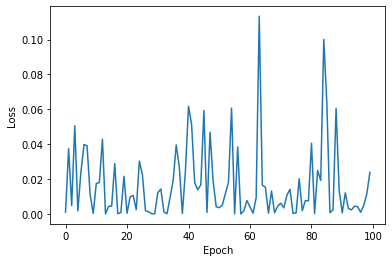

In [0]:
# !pip install tensorboard
# !tensorboard --logdir=runs
# from torch.utils.tensorboard import SummaryWriter
# import torchvision

import torch
import torch.nn as nn
from torch import optim
import torch.nn.functional as F
import matplotlib.pyplot as plt

class Net(nn.Module):
  def __init__(self, n_feature, n_hidden, n_output):
        super(Net, self).__init__()
        self.hidden = nn.Linear(n_feature, n_hidden)   # hidden layer
        self.predict = nn.Linear(n_hidden, n_output)   # output layer

  def forward(self, x):
        x = F.relu(self.hidden(x))  # activation function for hidden layer
        #print("Relu x: ",x)
        x = self.predict(x)             # linear output
        #print("Predict x: ",x)
        return x

INPUT_SIZE = num_reviews_per_app
OUTPUT_SIZE = 1 # regression to reach average rating
HIDDEN_SIZE = 100 # arbitrary
learning_rate = 0.001

net = Net(n_feature=INPUT_SIZE, n_hidden=HIDDEN_SIZE, n_output=OUTPUT_SIZE)
optimizer = optim.Adam(net.parameters(), lr=learning_rate)
loss_func = nn.MSELoss()
#loss_func = nn.L1Loss()
# writer = SummaryWriter()

num_epochs = 100
losses = []
for i in range(num_epochs):
  for batch_idx, samples in enumerate(train_dataloader):
    x,y = samples
    
    optimizer.zero_grad()   # clear gradients for next train
    prediction = net(x)
    loss = loss_func(prediction, y)
   
    loss.backward()         # backpropagation, compute gradients
    optimizer.step()        # apply gradients
    # if batch_idx%100 == 0:
    #   print("train label:", y)
    #   print("pred:", prediction)

    # for plotting
  if i % 10 == 0:
      print("Epoch ", i, ", Loss: ", loss)
  losses.append(loss)
  
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.plot(range(len(losses)),losses)

Given reviews:
 tensor([[0.8184, 0.9442, 0.7456, 0.4194, 0.8184, 0.4967, 0.4967, 0.0381, 0.4967,
         0.4967, 0.9167, 0.7096, 0.7856, 0.4967, 0.2229, 0.4967, 0.2560, 0.4194,
         0.4194, 0.8184, 0.4967, 0.1080, 0.8184, 0.4194, 0.9921, 0.2229, 0.1080,
         0.8184],
        [0.1581, 0.8581, 0.9855, 0.3169, 0.9882, 0.9927, 0.9534, 0.9754, 0.9735,
         0.1581, 0.9788, 0.9735, 0.9855, 0.1790, 0.9534, 0.8123, 0.9735, 0.9740,
         0.6946, 0.2560, 0.8123, 0.8798, 0.9762, 0.9735, 0.1581, 0.8680, 0.8118,
         0.1581],
        [0.5417, 0.6574, 0.6574, 0.7096, 0.7096, 0.7192, 0.7777, 0.7096, 0.7096,
         0.8184, 0.7782, 0.9401, 0.8123, 0.7192, 0.6574, 0.8123, 0.7856, 0.6462,
         0.4967, 0.1381, 0.1381, 0.6462, 0.7368, 0.4967, 0.5417, 0.5417, 0.4967,
         0.4967],
        [0.4967, 0.7192, 0.8299, 0.1529, 0.7192, 0.9798, 0.1529, 0.8299, 0.1812,
         0.6391, 0.7192, 0.6574, 0.9045, 0.4967, 0.2839, 0.7192, 0.8299, 0.8299,
         0.9386, 0.4967, 0.7192, 0.9045

/usr/local/lib/python3.6/dist-packages/torch/nn/modules/loss.py:431: UserWarning: Using a target size (torch.Size([5])) that is different to the input size (torch.Size([5, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.6/dist-packages/torch/nn/modules/loss.py:431: UserWarning: Using a target size (torch.Size([4])) that is different to the input size (torch.Size([4, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


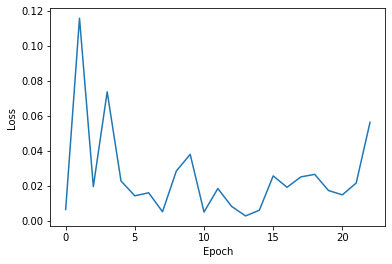

In [0]:
losses = []
for batch_idx, samples in enumerate(val_dataloader):
  x, y = samples
  prediction = net(x)
  print("Given reviews:\n", x)
  # for i in range(len(x)):
  #   print("Average of given review", sum(x[i])/28)
  print("Actual Average Rating:\n", y)
  #normalize into range of 0 to 5
  # for i in prediction:
  #   prediction[i] = float(prediction[i])*5
  print("Predicted:\n ", prediction)
  loss = loss_func(prediction, y)
  losses.append(loss)
  
plt.xlabel("Epoch") 
plt.ylabel("Loss")
plt.plot(range(len(losses)),losses)